## *ScreeNOT*: Usage example in `Python`

This notebook demonstrates the usage of the `ScreeNOT' package by following a stylized example.

#### Usecase summary:
1. `X` is a low-rank, unknown signal matrix.
2. `Z` is a noise matrix (also unknown). Its rows and columns are can be correlated, the covariance structure being completely unknown.
3. We observe `Y=X+Z`. **Goal**: Threshold the singular values of `Y` so to get an estimator `Xest` of `X`. We aim to choose the threshold so to minimize the Frobenius loss: `||X-Xest||_F^2`.


The following command downloads the ScreeNOT code package from PyPI:

In [41]:
pip install screenot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We start with some necessary imports:

In [42]:
import numpy as np    # Numpy
from screenot.ScreeNOT import adaptiveHardThresholding   # ScreeNOT main API function

import matplotlib.pyplot as plt  # for plotting figures

Our matrices will have the same number of rows and columns ```n=p=500```, the rank of ```X``` being ```r=10```, with non-zero singular values ```0.5,1.0,...,5.0``` and uniformly distributed left and right singular vectors. The following code generate such signal matrix:

In [43]:
n = p = 500

r = 10
x = np.arange(0.5, 0.5 + 0.5*r, 0.5)

G = np.random.normal(0, 1, (n,p))  # generate a gaussian i.i.d matrix
U, _, Vt = np.linalg.svd(G)  # U, Vt are uniformly random orthogonal matrices, due to the orthogonal invariance of G
X = U[:,0:r] @ np.diag(x) @ Vt[0:r,:]

For starters, suppose that the noise matrix `Z` has i.i.d. Gaussian entries with mean zero and variance 1/n. We generate such random matrix:

In [44]:
Z_gauss = np.random.normal(0, 1, (n,p)) / np.sqrt(n)

Remark: As n,p grow, the empirical singular value distribution of ```Z_gauss``` tends to a Marcenko-Pastur law (with shape parameter ```p/n=1```). 

Let's plot a histogram of the singular values of ```Z```:


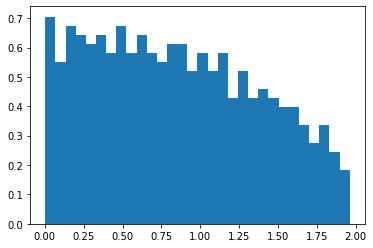

In [45]:
_, fZ_gauss, _ = np.linalg.svd(Z_gauss)
plt.hist(fZ_gauss, bins=30, density=True);

We apply ScreeNOT on the matrix ```Y_gauss = X + Z_gauss```, giving the upper bound of ```k=20``` on the rank of ```X```. For reconstructing the upper tail of the estimated noise spectral distribution, we use the "imputation" method, passing the parameter `strategy='i'` to the ScreeNOT API function. 

Note: the paramter `strategy` is optional; its default value being `strategy='i'`.

In [46]:
Y_gauss = X + Z_gauss
k = 20

Xest_gauss, Topt_gauss, r_eff_gauss = adaptiveHardThresholding(Y_gauss, k, strategy='i')

The threshold ScreeNOT computed, and number of principal components retained are:

In [47]:
Topt_gauss, r_eff_gauss

(2.3696056582940876, 7)

Note that the estimated threshold is quite close to $\frac{4}{\sqrt{3}} \approx 2.3$, which is the well-known asymptotically optimal hard threshold (with respect to Frobenius norm) for i.i.d centered noise (with variance $1/n$), see Gavish and Donoho 2014. This threshold was recovered in a completely data-adaptive manner.


Let's now try a different noise matrix ```Z```, this time allowing correlations inside rows of ```Z```. Specifically, every row $\mathbf{z}$ is sampled from an AR(1) process with parameter $\rho=0.6$:
$z_1 = e_1$ and $z_t = \rho z_{t-1} + \sqrt{1-\rho^2}e_t$ for $t\ge 2$, where $e_1,\ldots,e_p \sim N(0,1/n)$.

In [48]:
def AR1_Noise(n, p, rho):
    Z = np.zeros((n,p))
    for i in range(0,n):
        Z[i,0] = np.random.normal(0,1)
        for j in range(1,p):
            Z[i,j] = rho*Z[i,j-1] + np.sqrt(1-rho**2)*np.random.normal(0,1)
    return Z/np.sqrt(n)

Z_AR1 = AR1_Noise(n,p,0.6)

The distribution of singular values of ```Z_AR1``` looks quite different from a Marcenko-Pastur (say with shape p/n=1), despite the fact that each entry has mean $0$ and variance $1/n$:

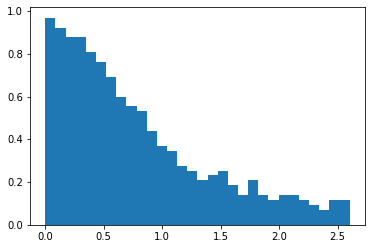

In [49]:
_, fZ_AR1, _ = np.linalg.svd(Z_AR1)
plt.hist(fZ_AR1, bins=30, density=True);

We run ScreeNOT on ```Y_AR1 = X + Z_AR1```. The procedure returns three values:
1. `Xest_AR1`: An estimate of `X`, obtained by thresholding the singular values of `Y`.
2. `Topt_AR1`: The optimal threshold computed by the ScreeNOT procedure.
3. `r_eff_AR1`: The number of retained PCs; = `rank(Xest_AR1)`.

In [50]:
Y_AR1 = X + Z_AR1
Xest_AR1, Topt_AR1, r_eff_AR1 = adaptiveHardThresholding(Y_AR1, k)

(Topt_AR1, r_eff_AR1)

(3.0753702404428402, 5)

The produced threshold is quite far from $\frac{4}{\sqrt{3}}$.

We plot the first 30 empirical singular values of ```Y_AR1```:

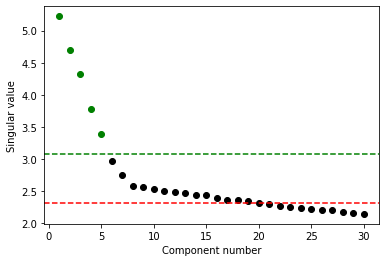

In [51]:
vals_count = 30
yU, fY, yVt = np.linalg.svd(Y_AR1)

plt.plot(range(1,r_eff_AR1+1), fY[0:r_eff_AR1], linestyle='None', marker='o', color='green');
plt.plot(range(r_eff_AR1+1,vals_count+1), fY[r_eff_AR1:vals_count], linestyle='None', marker='o', color='black');
plt.axhline(y=Topt_AR1, color='green', linestyle='--');
plt.axhline(y=4/np.sqrt(3), color='red', linestyle='--');
plt.xlabel(r'Component number');
plt.ylabel(r'Singular value');

The horizonal green line corresponds to ```Topt_AR1```, the threshold produced by ScreeNOT, while in red we have $\frac{4}{\sqrt{3}}$, the known optimal threshold for i.i.d noise.
We compare the Frobenius loss incurred at either threshold:

In [52]:
Topt_iid = 4/np.sqrt(3)

Xest_iid = yU @ np.diag( [y if y>Topt_iid else 0 for y in fY] ) @ yVt 

loss_ScreeNOT = np.linalg.norm(X - Xest_AR1)**2
loss_iid = np.linalg.norm(X - Xest_iid)**2

(loss_ScreeNOT, loss_iid)

(27.68277790715219, 97.50902453163373)

Indeed, we see that ScreeNOT achieves better (smaller) loss.